In [153]:
import pandas as pd
import numpy as np 
import pickle as pkl
import random
from collections import Counter
#from matplotlib import pyplot as plt


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import os

In [13]:
def load_dataset(filename):
    dataset = pd.read_csv(filename,index_col = "ACCT_ID", usecols = ["TR_TM","ACCT_ID","TR_AMT","TR_BAL_AMT"])
    dataset["TR_TM"] = dataset["TR_TM"].apply(pd.to_datetime)
    return dataset


def normalize(dataset):
    scaler = MinMaxScaler()
    return scaler.fit_transform(dataset)



def get_negtive_account(filename):
    return set(pd.read_csv(filename)["ACCT_ID"].values)
    

def create_trainset_label(filtered_positive_dataset, negetive_dataset):
    labels = np.array([1] * filtered_positive_dataset.shape[0] + [0] * negetive_dataset.shape[0])
    filtered_positive_dataset = filtered_positive_dataset.append(negetive_dataset)
    filtered_positive_dataset.fillna(method = "backfill",inplace = True)
    #filtered_positive_dataset = normalize(filtered_positive_dataset)

    return filtered_positive_dataset,labels

In [8]:
training_dataset_filename = "T3H_TRANS_MODEL_WW_DATA_TABLE.csv"
case_filename = "T3H_TRANS_YSB_WW_DATA_TABLE.csv"
new_dataset = "T3H_TRANS_ALL_WW_DATA_TABLE.csv"



if not os.path.exists("sup_cases.pkl") or not os.path.exists("sup_training_dataset.pkl"):

    ## ------- 数据读取接口 --------
    training_dataset = load_dataset(training_dataset_filename)
    cases = get_negtive_account(case_filename)

    with open("sup_cases.pkl","wb") as f:
        pkl.dump(cases,f)
    with open("sup_training_dataset.pkl","wb") as f:
        pkl.dump(training_dataset,f)
else:
    with open("sup_cases.pkl","rb") as f:
        cases = pkl.load(f)
    with open("sup_training_dataset.pkl","rb") as f:
        training_dataset = pkl.load(f)

    print("abnormal account: " + str(len(cases)))
    print("raw training dataset shape: " + str(training_dataset.shape))

abnormal account: 32
raw training dataset shape: (23115, 3)


## 异常账号的交易笔数最小为2

In [10]:
for name ,group in training_dataset.groupby("ACCT_ID"):
    if name in cases:
        print(group.shape)

(1218, 3)
(56, 3)
(5, 3)
(17, 3)
(447, 3)
(421, 3)
(921, 3)
(1152, 3)
(471, 3)
(446, 3)
(887, 3)
(557, 3)
(435, 3)
(782, 3)
(325, 3)
(1079, 3)
(21, 3)
(1896, 3)
(289, 3)
(114, 3)
(125, 3)
(150, 3)
(33, 3)
(2, 3)
(107, 3)
(231, 3)
(2227, 3)
(62, 3)
(199, 3)
(656, 3)
(380, 3)
(2, 3)


## 过滤账号

In [111]:
filtered_dataset = training_dataset.loc[training_dataset.groupby("ACCT_ID").size() > 1,:]
print(filtered_dataset.shape)

(22886, 3)


## 特征转换

In [119]:
def get_days_diff(grouped):
    def row_func(diff):
        return diff.days+1

    timeseries = grouped["TR_TM"].max() - grouped["TR_TM"].min()
    timeseries = timeseries.apply(row_func)
    return timeseries

def transform_feature(dataset):
    grouped = dataset.groupby("ACCT_ID")

    data_dict = {
                 "TRANS_COUNT": grouped.size(),
                 "TR_SUM": grouped["TR_AMT"].sum(),
                 "TR_MEAN": grouped["TR_AMT"].mean(), 
                 "TR_STD":grouped["TR_AMT"].std(),
                 "BAL_PERCENT": grouped["TR_BAL_AMT"].mean()/grouped["TR_AMT"].mean(), 
                 "TR_FREQ": grouped.size()/get_days_diff(grouped)
    }
    
    transformed_dataset = pd.DataFrame(data_dict)
    transformed_dataset = transformed_dataset.replace([np.inf, -np.inf], np.nan).fillna(value=0).astype(np.float64)

    return transformed_dataset

transform_dataset = transform_feature(filtered_dataset)
print(transform_dataset.shape)
transform_dataset.head(10)

(320, 6)


,TRANS_COUNT,TR_SUM,TR_MEAN,TR_STD,BAL_PERCENT,TR_FREQ
ACCT_ID,,,,,,
02AD7DADF145AF10A94E45DB89F5F6C019B9A28D2E5A8DC93DFF33072487A36964C2674AFA7691149ACB1990153A682BD295A48E47F6D758344E08390927A9EE37F9E1B414BF33FBD14BF717B98182B9,2.0,98000.00,4.900000e+04,7.071068e+02,0.012008,1.000000
03D53AFA37BB1788B17B42482384F42A9115C7C71A6D6C6E944CF6947FA90A66A3A3330DD9A7605C7C2874D8E49067A97150822ACE891F5AC6F45232FBA352ED9C682C1F97E65F55D80526910212FBE7,3.0,6530.00,2.176667e+03,2.025070e+03,2.102070,0.428571
054D8E05DFDAD8B28A3F4C7127A6302F8731617A0879F106D43F2907D697F82450B7B4FB5B9FB40B7C877A64B9F61F7DB3274A4D6C17D41E3D817DADA13ED7CCACFBECE6724E15F5F4C6783D8B965F0D,2.0,31829.00,1.591450e+04,8.364366e+03,10.351069,2.000000
0578852356A8A52E89B99181610B7DE999A07436CF2C02EDF9774C072E2024EF7DE7433FFF438FB45DE01A2AC5370952EB6D52397C4ACD130B856BA467DB46A24B2ADDBC981CD3E216F9AFDE75BA7FBE,196.0,7749496.84,3.953825e+04,2.172692e+05,5.111389,6.322581
0727967B7947DC38ECB1C9E4C015FCD03B727F7A8C289570813B79BB3D17F46EA7D2F7A6285AC62D9620F4AB4A05F00FDED8C366041D74EDBA31018A09C386F4BA0463442B6075E29EFCA5C0B0B4B91F,1218.0,1375761.84,1.129525e+03,2.438890e+03,4.278307,60.900000
07F9FFB53A9D6C45C3DA46BDD2900E57CCA8371194F32139642B57B250C808902250C6656B2CFB7E989B8BB4F9F5335E7442FED6B6C85AB7A163CF865156EA9CA862FEFDB6F6208578CD4274C5F5B583,5.0,62603.50,1.252070e+04,7.304568e+03,28.714313,2.500000
07F9FFB53A9D6C45C3DA46BDD2900E57CCA8371194F32139642B57B250C808904F0BE2C430BBA1AC33D61E2041B08FC27442F2801E31A149FB4A26404318D763AE69204524BF6A6703E34E6FCFB4CEC0,24.0,69290000.00,2.887083e+06,6.619123e+06,1.121671,2.181818
07F9FFB53A9D6C45C3DA46BDD2900E57CCA8371194F32139642B57B250C80890FB5EBCCAE31027447DD7AA7588A872F736E89B6CD859EDB7B7AEEBB910E444C90BC9BEDB584CF6DF88508C2AFD9E6D90,4.0,60000000.00,1.500000e+07,1.000000e+07,1.000163,4.000000
08FAF98BA9DC976AE95FCF0149019F6A7D79B59B95E87B17132BAF63CA16E3AB8F9A8FFB4736609DFA5BD851F8154B203749C8BDBAC0ED3EDF11A704DE43689651445360B8565836263DC3E821F46D13,5.0,39749.20,7.949840e+03,1.749693e+04,2.485504,0.500000


## Nomralization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124bcc748>,
      dtype=object)

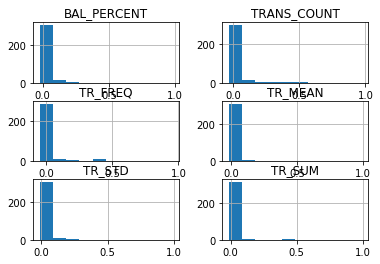

In [120]:
%matplotlib inline
all_features = (transform_dataset - transform_dataset.mean()) / (transform_dataset.max() - transform_dataset.min())
all_features.hist()

## 生成 label

In [122]:
all_features["Y"] = 1
all_features.loc[all_features.index.isin(cases),"Y"] = 0
labels = all_features["Y"].tolist()
print(Counter(labels))
all_features.drop(labels = "Y", axis = 1, inplace = True)
all_features.describe()

Counter({1: 288, 0: 32})


,TRANS_COUNT,TR_SUM,TR_MEAN,TR_STD,BAL_PERCENT,TR_FREQ
count,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02,3.200000e+02
mean,2.081668e-18,2.081668e-18,6.245005e-18,2.949030e-18,-1.561251e-17,-3.469447e-19
std,1.049051e-01,7.205833e-02,7.584229e-02,6.743581e-02,7.179119e-02,1.205508e-01
min,-3.124438e-02,-1.221634e-02,-1.423793e-02,-1.318973e-02,-2.294604e-02,-4.807726e-02
25%,-3.079494e-02,-1.219732e-02,-1.416824e-02,-1.314192e-02,-1.975874e-02,-4.368992e-02
50%,-2.944663e-02,-1.210373e-02,-1.402516e-02,-1.298779e-02,-1.542901e-02,-3.816400e-02
75%,-2.045787e-02,-1.119403e-02,-1.316057e-02,-1.192905e-02,-8.721033e-03,-2.236474e-02
max,9.687556e-01,9.877837e-01,9.857621e-01,9.868103e-01,9.770540e-01,9.519227e-01


## xgboost 

In [162]:
X_train, X_test, y_train, y_test = train_test_split(all_features,labels,test_size=0.3, random_state=42)

# sm = SMOTE(sampling_strategy = 0.01,random_state=42)
# training_dataset,labels = sm.fit_resample(X_train,y_train)
# print("final training dataset shape: {}".format(Counter(labels)))


print("------------------\n")
print("tune parameters: ......")

tuned_parameters = {
    "max_depth":list(range(0,10,2)),
    "min_child_weight":list(range(1,10,2)),
    "scale_pos_weight" : [Counter(labels)[1] / Counter(labels)[0],Counter(labels)[0] / Counter(labels)[1]],
    "gamma":[i/10.0 for i in range(0,5)],
    "reg_alpha":[1e-5, 1e-2, 0.1, 1, 100]
}

scores = ['roc_auc']
for score in scores:
    print("# Tuning hyper-parameters for %s\n" % score)

    clf = GridSearchCV(XGBClassifier(), tuned_parameters, cv = 5,
                       scoring='%s' % score)
    
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:\n")
    print(clf.best_params_)
    
    
    y_true, y_pred = y_test, clf.predict(X_test)
    
    print(classification_report(y_true, y_pred))

------------------

tune parameters: ......
# Tuning hyper-parameters for roc_auc

Best parameters set found on development set:

{'gamma': 0.0, 'max_depth': 2, 'min_child_weight': 3, 'reg_alpha': 1e-05, 'scale_pos_weight': 9.0}
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.98      1.00      0.99        88

   micro avg       0.98      0.98      0.98        96
   macro avg       0.99      0.88      0.92        96
weighted avg       0.98      0.98      0.98        96



/Users/ZRC/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
